# Learning progress: Evaluación del BERT a lo largo de las etapas del finetuning

Lo vamos a hacer primero con un conjunto de prueba:
* Abstracts de los que se tomó la muestra: [abstracts.csv](../../pubmed-queries/abstracts/abstracts.csv)
* Muestra fenotipos/etiquetas: [index-phenotypes.csv](../../pubmed-queries/abstracts/index-phenotypes.csv)
* Fenotipos test: [phenotypes-22-12-15.csv](../../pubmed-queries/results/phenotypes-22-12-15.csv) = nodos hoja HPO:PhenotypicAbnormality

Pasos a seguir:
1. Cargar todos los datos:
  * BERT de partida.
  * Ontología.
  * Datos crudos de entrenamiento (abstracts+fenotipos).
2. Preparar el entrenamiento:
  * Datos procesados de train (dataloaders)
  * Función de pérdida: BatchAllTripletLoss
  * Función de evaluación:
    * a) EmbeddingSimilarityEvaluator
      * Preparar pares de fenotipos (train/test?)
      * Calcular gold scores
    * b) Implementarla (SentenceEvaluator) con la funcionalidad:
      * Calcular MSE y correlación Train/Test.
      * Escribir datos en un csv.
      * Devolver la correlación de Test.
3. Fit: probar en el servidor y guardar los resultados.
4. Out: mostrar e interpretar los resultados.
  * Gráfica MSE / etapa (train/test)
  * Gráfica correlación / etapa (train/test)

## 1. Cargar todos los datos

In [33]:
# IMPORTS
from cmath import nan
import sentence_transformers
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [34]:
# 1. Cargar todos los datos (crudos)
from pyhpo import Ontology
import os

SRCPATH = '../..'
SEED = 42

# 1.1 BERT de partida

PRITAMDEKAMODEL = 'pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb'
bertmodel = SentenceTransformer(PRITAMDEKAMODEL)
model = bertmodel

# 1.2 Ontología

onto = Ontology(SRCPATH+ '/pubmed-queries/hpo-22-12-15-data')

# 1.3 Datos crudos de entrenamiento

PATH_DATA = SRCPATH + '/pubmed-queries/abstracts'
PATH_DATA_CSV = PATH_DATA + '/abstracts.csv'
PATH_DATA_FENOTIPOS = SRCPATH + '/pubmed-queries/results/phenotypes-22-12-15.csv'
PATH_INDEX_FENOTIPOS = PATH_DATA + '/index-phenotypes.csv'

# abstracts
dfPapers = pd.read_csv(PATH_DATA_CSV, sep='\t', low_memory=False, na_values=['', nan])
# fenotipos test
dfPhenotypes = pd.read_csv(PATH_DATA_FENOTIPOS, sep=';', low_memory=False, na_values=['', nan])
# fenotipos train
dfIndex = pd.read_csv(PATH_INDEX_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])

# Guardar en directorio manejable
PATH_TRAINDATA = SRCPATH + '/traindata'

# crear directorios si no existen
for dir in [PATH_TRAINDATA, PATH_TRAINDATA + '/abstracts',
            PATH_TRAINDATA + '/phenotypes', PATH_TRAINDATA + '/onto']:
    if not os.path.exists(dir):
        os.makedirs(dir)

dfPapers.to_csv(PATH_TRAINDATA + '/abstracts/abstracts.csv', sep='\t', index=False)
dfPhenotypes.to_csv(PATH_TRAINDATA + '/phenotypes/phenotypes.csv', sep=';', index=False)
dfIndex.to_csv(PATH_TRAINDATA + '/phenotypes/index.csv', sep='\t', index=False)

# copiar ontology al directorio tambien
os.system('cp -r ' + SRCPATH + '/pubmed-queries/hpo-22-12-15-data ' + PATH_TRAINDATA + '/onto')


0

## 2. Preparar el entrenamiento

In [35]:
# Procesar los datos de train/loss/test

# 2.1. Clean abstracts

# Tratar NA's en la columna abstracts -> cambiar por el título
def getPhenDesc(phenotypeName):
    hpoNode = onto.get_hpo_object(phenotypeName) 
    description = hpoNode.definition if hpoNode.definition else '""'
    return description

print('Na\'s:', dfPapers['abstract'].isna().sum())
dfPapers['abstract'] = dfPapers['abstract'].fillna(dfPapers['title'])

# Función clean abstract

# Download the stopwords from NLTK
PATH_NTLK = os.path.realpath(SRCPATH + '/traindata/nltk')
if not os.path.exists(PATH_NTLK):
    os.makedirs(PATH_NTLK)

os.environ['NLTK_DATA'] = PATH_NTLK

nltk.download('punkt')
nltk.download('stopwords')

cached_stopwords = stopwords.words('english')
def clean_abstract(abstract):
    if isinstance(abstract, float) and np.isnan(abstract):
        return ''
    # Convert the text to lowercase
    abstract = abstract.lower()

    # Remove punctuation
    abstract = abstract.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(abstract)

    # Remove stopwords
    tokens = [word for word in tokens if not word in cached_stopwords]

    # Join the tokens back into a single string
    abstract = ' '.join(tokens)

    return abstract

# Save clean abstracts csv

dfPapers['clean_abstract'] = dfPapers['abstract'].apply(clean_abstract)
dfPapers.drop(columns=['abstract'], inplace=True)
dfPapers.to_csv(PATH_TRAINDATA + '/abstracts/abstracts-clean.csv', sep='\t', index=False)

print('Clean abstracts in: ', PATH_TRAINDATA + '/abstracts/abstracts-clean.csv')
print('Total abstracts: ', len(dfPapers))

# 2.2 Tags = phenotypes (train)

tags = dfIndex['phenotypeName']
numlabels = len(tags)
print('Number of phenotype tags:', numlabels)
mapping = {tag: i for i, tag in enumerate(tags)}

def getLabelNumber(phenotypeName):
    return mapping[phenotypeName]

Na's: 1854


[nltk_data] Downloading package punkt to /home/domingo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/domingo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clean abstracts in:  ../../traindata/abstracts/abstracts-clean.csv
Total abstracts:  23226
Number of phenotype tags: 100


### 2.3 Profiling
Tomamos solo una muestra del 5% de los abstracts totales para realizar las pruebas más rápido. Cuando funcionen las pruebas se cambia para la versión oficial del experimento.

In [36]:
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, evaluation, InputExample

PROFILING = True
SAMPLEPERCENT = 0.005 if PROFILING else 1.0
SEED = 42
torch.manual_seed(SEED)

dTrain = dfPapers.sample(frac=SAMPLEPERCENT, random_state=SEED)
numexamples = len(dTrain)
print('Number of train examples:', numexamples)
dTrain.to_csv(PATH_TRAINDATA + '/abstracts/abstracts-train.csv', sep='\t', index=False)

Number of train examples: 116


### 2.4 Dataloaders

In [37]:
# Ejemplos de entrenamiento

# pares (abstract,fenotipo)
abstractsTrain = [InputExample(texts=[clean_abstract(x)], label=mapping[y]) for x, y in zip(dTrain['clean_abstract'], dTrain['phenotypeName'])]
train_dataloader = DataLoader(abstractsTrain, shuffle=True, batch_size=16)

from itertools import combinations
import itertools
import random

# Ejemplos de evaluación (train)

def onto_sim(name1, name2):
    phen1 = onto.get_hpo_object(name1)
    phen2 = onto.get_hpo_object(name2)
    sim = min(phen1.similarity_score(phen2, method='lin'),1)
    return sim

# Son pares de fenotipos (con su gold score si es necesario)
dmp = pd.DataFrame(dfIndex, columns=['phenotypeName'])
index_pairs = combinations(range(0,len(dmp)), 2)

lpairs = list(combinations(dmp['phenotypeName'], 2))
ltrain1, ltrain2 = zip(*lpairs) # 2 listas diferentes para pasar como parámetro al evaluator

goldTrain = [onto_sim(pair[0], pair[1]) for pair in lpairs]

# Ejemplos de evaluación (test)

import random

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

# Obtén una lista de todos los valores únicos en la columna 'phenotypeName'

num_samples = 100  # Number of combinations to sample
print('Number of test pairs samples:', num_samples)

# Usa random_combination para obtener una muestra aleatoria de 2000 pares
sample_pairs = [random_combination(dfPhenotypes['Phenotype'], 2) for _ in range(num_samples)]
ltest1, ltest2 = zip(*sample_pairs)

goldTest = [onto_sim(pair[0], pair[1]) for pair in sample_pairs]

# Guardar los pares de evaluación

dfVal = pd.DataFrame({'phenotype1': ltrain1, 'phenotype2': ltrain2, 'lin': goldTrain})
dfTest = pd.DataFrame({'phenotype1': ltest1, 'phenotype2': ltest2, 'lin': goldTest})

if not os.path.exists(PATH_TRAINDATA + '/evaluation'):
    os.makedirs(PATH_TRAINDATA + '/evaluation')

dfVal.to_csv(PATH_TRAINDATA + '/evaluation/pairs-val.csv', sep='\t', index=False)
dfTest.to_csv(PATH_TRAINDATA + '/evaluation/pairs-test.csv', sep='\t', index=False)

Number of test pairs samples: 100


### 2.6 Funciones de pérdida y evaluación
* Primero probaremos la opción a) con la función predefinida EmbeddingSimilarityEvaluator para los datos de train.

In [38]:
# Loss function
from sentence_transformers.evaluation import SimilarityFunction

MARGIN = 0.3743
print(f'Loss Function: BatchAllTripletLoss(margin={MARGIN})')
train_loss = losses.BatchAllTripletLoss(model=model, distance_metric=losses.BatchHardTripletLossDistanceFunction.cosine_distance, margin=MARGIN)

# Evaluator

# a)

evaluatorTrain=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltrain1, ltrain2, goldTrain,
                                                                             main_similarity=SimilarityFunction.COSINE,
                                                                             name='train')
evaluatorTest=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltest1, ltest2, goldTest,
                                                                            main_similarity=SimilarityFunction.COSINE,
                                                                            name='test')
combined_evaluator = evaluation.SequentialEvaluator([evaluatorTrain, evaluatorTest],
                                                    main_score_function=lambda scores: scores[1])
# test score prevalece

print('Evaluator: EmbeddingSimilarityEvaluator(cosine_similarity)')

Loss Function: BatchAllTripletLoss(margin=0.3743)
Evaluator: EmbeddingSimilarityEvaluator(cosine_similarity)


### 3. Fit

In [39]:
num_epochs = 2
num_examples = len(dTrain)
ev_steps = len(train_dataloader)//5 # 5 evaluations per epoch

if not os.path.exists(SRCPATH + '/output'):
    os.makedirs(SRCPATH + '/output')

print(f'Fit parameters: num_epochs={num_epochs},',
      f'evaluation_steps={ev_steps},warmup_steps={int(0.25*(num_examples//16))}')

Fit parameters: num_epochs=2, evaluation_steps=1,warmup_steps=1


In [40]:
print("Fitting...")
import time
FITTED = False
if FITTED:
    model = SentenceTransformer(SRCPATH + '/output/fine-tuned-bio-bert-ev')
    execution_time = 2605.83
else:
    start_time = time.time()
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=combined_evaluator,
        epochs=num_epochs,
        #evaluation_steps=(num_examples//16)//num_epochs//2,
        evaluation_steps=ev_steps,
        warmup_steps=int(0.25*(num_examples//16)),
        output_path=SRCPATH+'/output/fine-tuned-bio-bert-ev',
        save_best_model=True,
        checkpoint_path='./checkpoint',
        checkpoint_save_steps=ev_steps,
        checkpoint_save_total_limit=num_epochs
    )

    end_time = time.time()
    execution_time = end_time - start_time

print(f"Execution time for model.fit: {execution_time:.2f} seconds")
fmodel = model # finetuned model

Fitting...


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/8 [00:00<?, ?it/s]

Execution time for model.fit: 2605.83 seconds


 ## Resultados
El modelo obtenido queda en el directorio [src/output/fine-tuned-bio-bert-ev](../../output/fine-tuned-bio-bert-ev/README.md) y en él hay un subdirectorio eval donde están los csv resultantes de los pasos de evaluación. Los pasos a seguir para analizar los resultados son:
1. Calcular score original del modelo model (train y test)
2. Obtener los y=scores (pearson) y x = train_step
3. Dibujar las gráficas de correlación de train y test
4. Analizar los resultados y determinar el próximo objetivo

In [41]:
# Cargar modelo de nuevo (se sobreescribe al hacer fit)
bertmodel = SentenceTransformer(PRITAMDEKAMODEL)
model = bertmodel

# 1. Calcular score original

EVPATH = SRCPATH + '/output/fine-tuned-bio-bert-ev/eval'
scoreTrain = evaluatorTrain.__call__(model=bertmodel, output_path=EVPATH, epoch=0, steps=0)
scoreTest = evaluatorTest.__call__(model=bertmodel, output_path=EVPATH, epoch=0, steps=0)
print(f'Original score (spearman): {scoreTrain} (train), {scoreTest} (test)')

Original score (spearman): 0.056239004381953034 (train), 0.1240971112258159 (test)


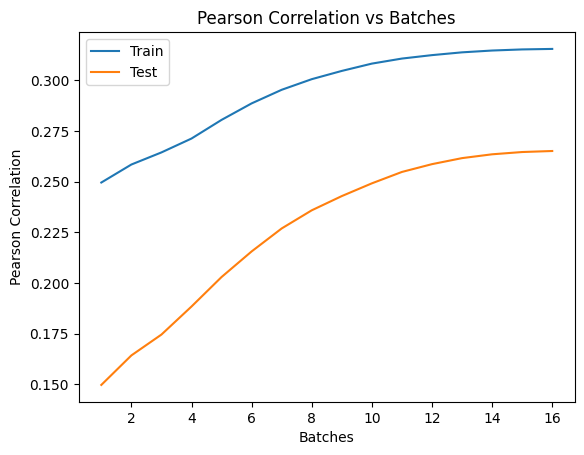

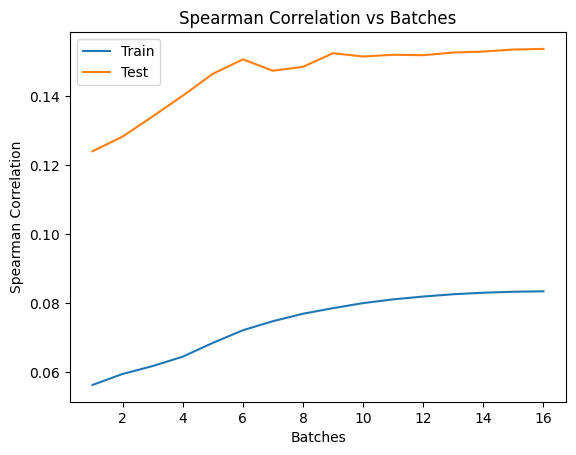

In [42]:
from matplotlib import pyplot as plt

# 2. Obtener los y=pearson, x=steps

dfScoreTrain = pd.read_csv(EVPATH + '/similarity_evaluation_train_results.csv')
dfScoreTest = pd.read_csv(EVPATH + '/similarity_evaluation_test_results.csv')

def sort_dfScores(df, ev_steps, tam_epoch):
    df['batch_count'] = df['epoch']*tam_epoch + df['steps']*ev_steps
    return df.sort_values('batch_count')

dfScoreTrain = sort_dfScores(dfScoreTrain, ev_steps, len(train_dataloader))
dfScoreTest = sort_dfScores(dfScoreTest, ev_steps, len(train_dataloader))

def get_data(df, ev_steps, train_dataloader):
    x = []
    y = []
    z = []

    for row in df.iterrows():
        if row[1]['steps'] <= 0:
            continue
        x_val = row[1]['batch_count']
        y_val = row[1]['cosine_pearson']
        z_val = row[1]['cosine_spearman']
        x.append(x_val)
        y.append(y_val)
        z.append(z_val)
    
    return x, y, z

def plot_data(xtrain, ytrain, xtest, ytest, ylabel):
    plt.plot(xtrain, ytrain, label='Train')
    plt.plot(xtest, ytest, label='Test')
    xlabel = 'Batches'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(ylabel + ' vs ' + xlabel)
    plt.legend()
    plt.show()

# 2. Obtener los datos
xtrain, ytrain, ztrain = get_data(dfScoreTrain, ev_steps, train_dataloader)
xtest, ytest, ztest = get_data(dfScoreTest, ev_steps, train_dataloader)

# 3. Graficar
plot_data(xtrain, ytrain, xtest, ytest, 'Pearson Correlation')
plot_data(xtrain, ztrain, xtest, ztest, 'Spearman Correlation')

## Interpretación
Vemos que la correlación de Pearson aumenta durante todo el entrenamiento pero la de Spearman disminuye en el caso de los pares de Test. He puesto la de Spearman también porque en la función EmbeddingSimilarityEvaluator de la librería es la que se usa por defecto para determinar el mejor modelo. Hace falta una prueba con un tamaño mayor y más epochs para sacar conclusiones. Así se verá cuándo empieza a bajar la curva de Pearson, que es cuando seguro el modelo está sobreaprendiendo.

La prueba de Spearman sugiere que va a haber malos resultados pero todavía quedan cosas por probar para mejorarlos:
* Falta ver el MSE.
* Utilizar un conjunto de fenotipos más apropiado.
  * Los nodos hoja no están bien representados en la ontología (casi todos tienen similitud lin ~ 0 seguramente porque no aparecen frecuentemente).
  * Consecuentemente, volver a obtener un corpus de abstracts con las búsquedas de los nuevos fenotipos.
  * Volver a obtener los pares de evaluación de train y test.
* Cambiar los hiperparámetros. Aquí habíamos usado:
  * warmup_steps = $0.25 * N // batch_{size}$
  * $lr = 2^{-5}$
  * weight_decay = 0.01
* Cambiar la función de pérdida:
  * BatchAllTripletLoss(margin=0.3743): podemos seguir usándola o cambiar el margin. Yo pienso que tiene sentido para estos pares (abstract,fenotipo) porque al buscarlos en pubmed el abstract deberá ser parecido al fenotipo (con un margen).
  * Usar otra: CosineSimilarityLoss, CoSENTLoss... Estas funciones requieren otro tipo de datos de entrenamiento y por eso las descarté al principio. Necesitan un par de textos (abstract1, abstract2) y su label de similitud "gold". En este caso podríamos tomar como gold la distancia lin entre los fenotipos de búsqueda. El sesgo que se introduce es que se supone que la distancia entre los abstracts será parecida a la de los fenotipos. Es lo más parecido a usar directamente "deltas" en la pérdida $$\Delta(x,y) = (cos_{dist}(x,y) - gold) ^2$$
  
## Implementación MSE Evaluation

In [43]:
from sentence_transformers.evaluation import SentenceEvaluator, SimilarityFunction
import logging
import os
import csv
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from scipy.stats import pearsonr, spearmanr
import numpy as np
from typing import List, Literal, Optional
from sentence_transformers import InputExample


logger = logging.getLogger(__name__)


class MSESimilarityEvaluator(SentenceEvaluator):
    """
    Evaluate a model based on the similarity of the embeddings by calculating the MSE
    in comparison to the gold standard labels.
    The metrics are the cosine similarity as well as euclidean and Manhattan distance.
    The returned score is the MSE with a specified metric.

    The results are written in a CSV. If a CSV already exists, then values are appended.
    """

    def __init__(
        self,
        sentences1: List[str],
        sentences2: List[str],
        scores: List[float],
        batch_size: int = 16,
        main_similarity: SimilarityFunction = None,
        name: str = "",
        show_progress_bar: bool = False,
        write_csv: bool = True,
        precision: Optional[Literal["float32", "int8", "uint8", "binary", "ubinary"]] = None,
    ):
        """
        Constructs an evaluator based for the dataset

        The labels need to indicate the similarity between the sentences.

        :param sentences1:  List with the first sentence in a pair
        :param sentences2: List with the second sentence in a pair
        :param scores: Similarity score between sentences1[i] and sentences2[i]
        :param write_csv: Write results to a CSV file
        :param precision: The precision to use for the embeddings. Can be "float32", "int8", "uint8", "binary", or
            "ubinary". Defaults to None.
        """
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.scores = scores
        self.write_csv = write_csv
        self.precision = precision

        assert len(self.sentences1) == len(self.sentences2)
        assert len(self.sentences1) == len(self.scores)
        
        self.main_similarity = main_similarity
        self.name = name

        self.batch_size = batch_size
        if show_progress_bar is None:
            show_progress_bar = (
                logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG
            )
        self.show_progress_bar = show_progress_bar

        self.csv_file = (
            "MSE_similarity_evaluation"
            + ("_" + name if name else "")
            + ("_" + precision if precision else "")
            + "_results.csv"
        )
        self.csv_headers = [
            "epoch",
            "steps",
            "cosine_MSE",
            "euclidean_MSE",
            "manhattan_MSE",
            "dot_MSE",
        ]

    @classmethod
    def from_input_examples(cls, examples: List[InputExample], **kwargs):
        sentences1 = []
        sentences2 = []
        scores = []

        for example in examples:
            sentences1.append(example.texts[0])
            sentences2.append(example.texts[1])
            scores.append(example.label)
        return cls(sentences1, sentences2, scores, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        if epoch != -1:
            if steps == -1:
                out_txt = " after epoch {}:".format(epoch)
            else:
                out_txt = " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logger.info("EmbeddingSimilarityEvaluator: Evaluating the model on " + self.name + " dataset" + out_txt)
        if self.precision is not None:
            embeddings1 = model.encode(
                self.sentences1,
                batch_size=self.batch_size,
                show_progress_bar=self.show_progress_bar,
                convert_to_numpy=True,
                precision=self.precision,
                normalize_embeddings=bool(self.precision),
            )
            embeddings2 = model.encode(
                self.sentences2,
                batch_size=self.batch_size,
                show_progress_bar=self.show_progress_bar,
                convert_to_numpy=True,
                precision=self.precision,
                normalize_embeddings=bool(self.precision),
            )
            # Binary and ubinary embeddings are packed, so we need to unpack them for the distance metrics
            if self.precision == "binary":
                embeddings1 = (embeddings1 + 128).astype(np.uint8)
                embeddings2 = (embeddings2 + 128).astype(np.uint8)
            if self.precision in ("ubinary", "binary"):
                embeddings1 = np.unpackbits(embeddings1, axis=1)
                embeddings2 = np.unpackbits(embeddings2, axis=1)
        else:
            embeddings1 = model.encode(
                self.sentences1,
                batch_size=self.batch_size,
                show_progress_bar=self.show_progress_bar,
                convert_to_numpy=True,
            )
            embeddings2 = model.encode(
                self.sentences2,
                batch_size=self.batch_size,
                show_progress_bar=self.show_progress_bar,
                convert_to_numpy=True,
            )

        labels = self.scores

        cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))
        manhattan_distances = -paired_manhattan_distances(embeddings1, embeddings2)
        euclidean_distances = -paired_euclidean_distances(embeddings1, embeddings2)
        dot_products = np.array([np.dot(emb1, emb2) for emb1, emb2 in zip(embeddings1, embeddings2)])

        eval_mse_cosine = np.mean((cosine_scores - labels) ** 2)
        eval_mse_manhattan = np.mean((manhattan_distances - labels) ** 2)
        eval_mse_euclidean = np.mean((euclidean_distances - labels) ** 2)
        eval_mse_dot = np.mean((dot_products - labels) ** 2)

        logger.info(
            "Cosine-Similarity :\tMSE: {:.6f}".format(eval_mse_cosine)
        )
        logger.info(
            "Manhattan-Distance:\tMSE: {:.6f}".format(eval_mse_manhattan)
        )
        logger.info(
            "Euclidean-Distance:\tMSE: {:.6f}".format(eval_mse_euclidean)
        )
        logger.info(
            "Dot-Product-Similarity:\tMSE: {:.6f}".format(eval_mse_dot)
        )

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)
            with open(csv_path, newline="", mode="a" if output_file_exists else "w", encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow(
                    [
                        epoch,
                        steps,
                        eval_mse_cosine,
                        eval_mse_euclidean,
                        eval_mse_manhattan,
                        eval_mse_dot,
                    ]
                )

        if self.main_similarity == SimilarityFunction.COSINE:
            return eval_mse_cosine
        elif self.main_similarity == SimilarityFunction.EUCLIDEAN:
            return eval_mse_euclidean
        elif self.main_similarity == SimilarityFunction.MANHATTAN:
            return eval_mse_manhattan
        elif self.main_similarity == SimilarityFunction.DOT_PRODUCT:
            return eval_mse_dot
        elif self.main_similarity is None:
            return min(eval_mse_cosine, eval_mse_manhattan, eval_mse_euclidean, eval_mse_dot)
        else:
            raise ValueError("Unknown main_similarity value")

## Prueba MSE Evaluation 

In [44]:
# Cargar modelo de nuevo (se sobreescribe al hacer fit)
bertmodel = SentenceTransformer(PRITAMDEKAMODEL)
fmodel = SentenceTransformer(SRCPATH + '/output/fine-tuned-bio-bert-ev')

# 1. Calcular score original

EVPATH = SRCPATH + '/output/fine-tuned-bio-bert-ev/eval'

evaluatorMSETrain=MSESimilarityEvaluator(ltrain1, ltrain2, goldTrain,
                                                                             main_similarity=SimilarityFunction.COSINE,
                                                                             name='train')
evaluatorMSETest=MSESimilarityEvaluator(ltest1, ltest2, goldTest,
                                                                            main_similarity=SimilarityFunction.COSINE,
                                                                            name='test')

scoreTrain = evaluatorMSETrain.__call__(model=bertmodel, output_path=EVPATH, epoch=0, steps=0)
scoreTest = evaluatorMSETest.__call__(model=bertmodel, output_path=EVPATH, epoch=0, steps=0)
print(f'Original score (MSE): {scoreTrain} (train), {scoreTest} (test)')

scoreTrain = evaluatorMSETrain.__call__(model=fmodel, output_path=EVPATH, epoch=-1, steps=0)
scoreTest = evaluatorMSETest.__call__(model=fmodel, output_path=EVPATH, epoch=-1, steps=0)
print(f'Fine-tuned score (MSE): {scoreTrain} (train), {scoreTest} (test)')

Original score (MSE): 0.037398453988366664 (train), 0.041074534341806225 (test)
Fine-tuned score (MSE): 0.028498581513886016 (train), 0.02989110581049229 (test)


In [45]:
print(np.var(goldTrain), np.var(goldTest))

0.01004371225634582 0.0042774155067445635
